# ResNet Preprocessing - Modified for Multiphase Data

Copy this notebook and set the paths to start preprocessing your data.

Note: If you are going to update this notebooks, clear the outputs before committing.

## Imports

In [1]:
import os
import pathlib
import typing
import pandas as pd

import numpy as np

## Load Data

Load in some sample scans. Here we take out 20 positive scans.

In [2]:
def unzip(path):
    """
    unzips one npz file given path of file
    :param path: string path of a singular npz file
    :return: the contents of the zip file
    """
    files = np.load(path)
    return files

In [3]:
# data_dict = load_data('/home/elvo-analysis/data/numpy/')
dir_path = '/research/rih-cs/datasets/elvo-multiphase/v0.1/positive'

In [4]:
samples = []
sample_size = 20
i = 1
for npz_file in os.listdir(dir_path):
    if i > sample_size:
        break
    i += 1
    if npz_file.endswith(".npz"):  # ignore gstmp files
        npy_files = np.load(dir_path + '/' + npz_file)
        for file in npy_files:
            samples.append(npy_files[file])

Check that we have the correct number of scans in our sample. Expected: 20 x 3 = 60 3D numpy arrays in total

In [5]:
print(len(samples))

60


Check the shape of each of these 60 arrays. One key part of this preprocessing pipeline is to make every scan the same shape.

In [74]:
for scan in samples:
    print(scan.shape)

(1512, 230, 230)
(1344, 221, 178)
(1080, 222, 174)
(1896, 230, 230)
(1008, 199, 168)
(1056, 193, 168)
(1416, 230, 230)
(864, 176, 174)
(864, 176, 162)
(1320, 230, 230)
(1080, 203, 160)
(1080, 203, 172)
(1944, 230, 230)
(1152, 224, 193)
(1176, 225, 193)
(1416, 230, 230)
(888, 216, 211)
(960, 206, 201)
(1656, 230, 230)
(936, 197, 182)
(984, 197, 180)
(1920, 230, 230)
(960, 200, 154)
(984, 199, 150)
(1464, 230, 230)
(984, 186, 158)
(1032, 184, 160)
(1560, 230, 230)
(1104, 203, 180)
(1128, 203, 182)
(1560, 230, 230)
(1152, 181, 148)
(1176, 181, 148)
(1416, 230, 230)
(936, 197, 174)
(936, 199, 174)
(1656, 230, 230)
(1128, 229, 185)
(1200, 229, 188)
(1512, 230, 230)
(864, 195, 164)
(936, 195, 166)
(1824, 230, 230)
(1104, 203, 181)
(1056, 205, 181)
(1728, 230, 230)
(1272, 215, 201)
(1248, 215, 203)
(1536, 230, 230)
(960, 205, 166)
(984, 205, 168)
(888, 230, 230)
(1152, 258, 192)
(1152, 261, 183)
(1512, 230, 230)
(1152, 201, 160)
(1080, 205, 156)
(1968, 254, 230)
(1200, 258, 186)
(1200, 259, 1

In [72]:
# print(samples)

Sample plots to see whether the brain is relatively centered in the scan.

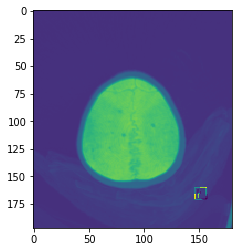

In [17]:
import matplotlib.pyplot as plt
plt.imshow(samples[20][983])
plt.show();

## Create MIPs

Cropping the image, applying mip, etc.

NOTE: We need to tweak this step so we start counting the slices from the TOP of the head, which is originally the greatest index in the array's z-dim. We do this by first 'flipping' the array along the z-dim.

In [33]:
def mip(arr: np.ndarray, start: int, thickness: int) -> np.ndarray:
    "return one MIP given a 3D array and a start index"
    mip = np.copy(arr)
    mip = mip[-start - thickness:-start]
    return np.amax(mip, axis=0)

def multichan_mip(arr: np.ndarray, start: int, thickness: int) -> np.ndarray:
    "return three MIPS given a 3D array and start index, counted from the TOP of the head"
    start_1 = start + thickness
    start_2 = start_1 + thickness
    
    return mip(arr, start, thickness), mip(arr, start_1, thickness), mip(arr, start_2, thickness)

In [34]:
# test mip function

In [47]:
mip_1, mip_2, mip_3 = multichan_mip(samples[0], 500, 5)

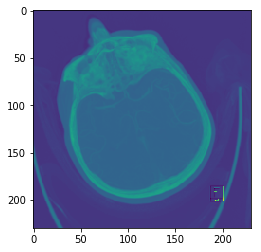

In [51]:
plt.imshow(mip_1)
plt.show();

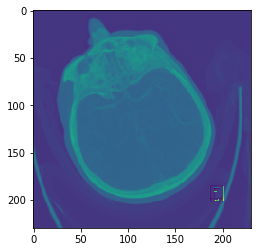

In [52]:
plt.imshow(mip_2)
plt.show();

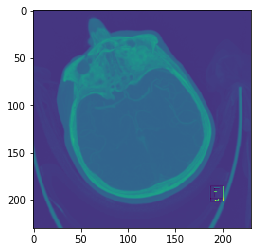

In [54]:
plt.imshow(mip_3)
plt.show();

## Reshape Images

Make all images the same shape after MIPing

In [149]:
import math

def center_reshape(arr: np.ndarray, size: tuple) -> np.ndarray:
    """
    crops a numpy array from the center, with equal spacing on edges
    if desired size is greater than array size, pad arrays with zeros
    specifically for 2d scans where only the x- and y-axes need reshaping AFTER miping
    """
    arr_size = arr.shape
    assert len(arr_size) == 2  # func intended for only 2d arrays
    assert len(size) == 2
    
    x_val = arr_size[0]
    y_val = arr_size[1]
    x_target = size[0]
    y_target = size[1]
    
    # pad with zeros if needed
    new_arr = np.copy(arr)
    if x_val < x_target:  # pad x
        diff = (x_target - x_val)
        x_pad = math.ceil(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = np.pad(arr, ((x_pad, x_pad), (0, 0)), 'constant', constant_values=(0, 0))
        else:
            new_arr = np.pad(arr, ((x_pad-1, x_pad), (0, 0)), 'constant', constant_values=(0, 0))
    if y_val < y_target:  # pad y
        diff = y_target - y_val
        y_pad = math.ceil(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = np.pad(new_arr, ((0, 0), (y_pad, y_pad)), 'constant', constant_values=(0, 0))
        else:
            new_arr = np.pad(new_arr, ((0, 0), (y_pad-1, y_pad)), 'constant', constant_values=(0, 0))
    
    # crop equally from both sides
    if x_val > x_target:  # crop x
        diff = x_val - x_target
        x_crop = math.floor(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = new_arr[x_crop:-x_crop]
        else:
            new_arr = new_arr[x_crop + 1:-x_crop]
    if y_val > y_target:  # crop x
        diff = y_val - y_target
        y_crop = math.floor(diff/2)
        if diff % 2 == 0: # deal with even vs odd and off-by-one error
            new_arr = [arr[y_crop:-y_crop] for arr in new_arr]
        else:
            new_arr = [arr[y_crop + 1:-y_crop] for arr in new_arr]
    
    return np.array(new_arr)
    

In [150]:
print(samples[1][500].shape)

(221, 178)


In [161]:
reshaped_mip_1 = center_reshape(samples[1][500], (200, 150))
print(reshaped_mip_1.shape)

(200, 150)


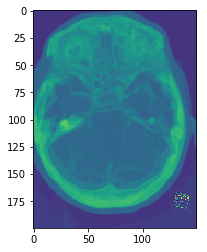

In [162]:
plt.imshow(reshaped_mip_1)
plt.show();

## Visualize

In [109]:
%matplotlib inline

from matplotlib import pyplot as plt

def plot_images(data: typing.List[np.ndarray],
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, scan in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        plt.imshow(scan[0])
    fig.tight_layout()
    plt.plot()

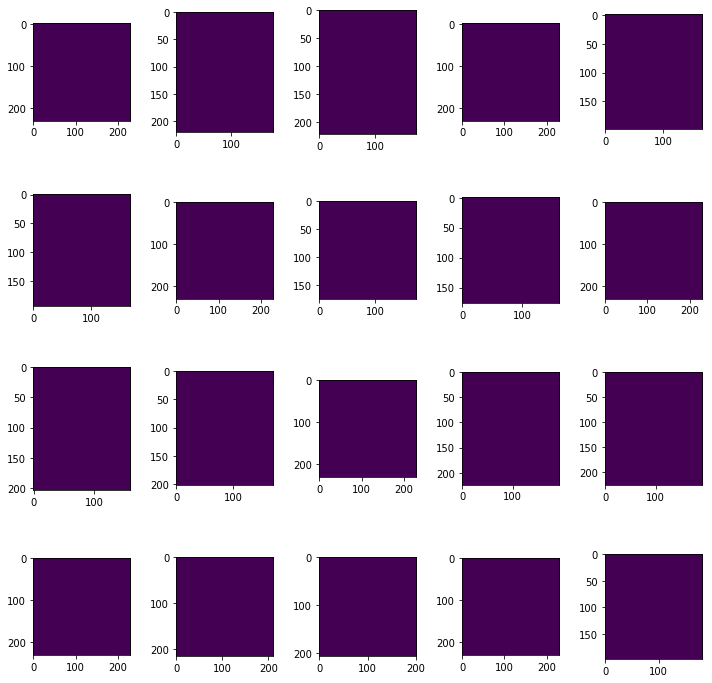

In [110]:
plot_images(mips, num_cols=5)